### 1. Importing libraries

In [9]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid
from torch.optim import Adam

### 2. Load dataset

In [3]:
# create a transofrm to apply to each datapoint
transform = transforms.Compose([transforms.ToTensor()])

# download the MNIST datasets
path = '~/datasets'
train_dataset = MNIST(path, transform=transform, download=True)
test_dataset  = MNIST(path, transform=transform, download=True)

# create train and test dataloaders
batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


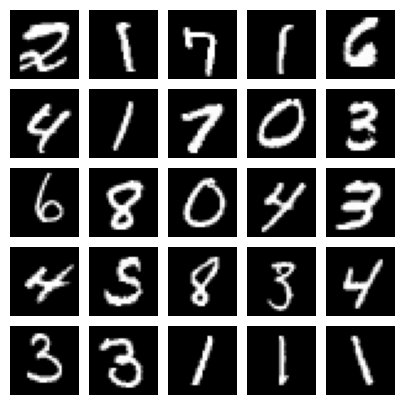

In [5]:
# get 25 sample training images for visualization
dataiter = iter(train_loader)
image = next(dataiter)

num_samples = 25
sample_images = [image[0][i,0] for i in range(num_samples)]

fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

plt.show()

Now, we create a simple VAE which has fully-connected encoders and decoders . The input dimension is 784 which is the flattened dimension of MNIST images (28×28). In the encoder, the mean (μ) and variance (σ²) vectors are our variational representation vectors. Notice that we multiply the latent variance with the epsilon (ε) parameter for reparameterization before decoding which allows us to perform backpropagation.

### 3. Implementaion of VAE

In [17]:
class VAE(nn.Module):

    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=200, device=device):
        super(VAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2)
            )

        # latent mean and variance
        self.mean_layer = nn.Linear(latent_dim, 2)
        self.logvar_layer = nn.Linear(latent_dim, 2)

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
            )

    def encode(self, x):
        x = self.encoder(x)
        mean, log_var = self.mean_layer(x), self.logvar_layer(x)
        return mean, log_var

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)
        z = mean + var*epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, log_var = self.encode(x)
        z = self.reparameterization(mean, log_var)
        x_hat = self.decode(z)
        return x_hat, mean, log_var

In [18]:
# define our model and optimizer
model = VAE().to(device)
optimizer = Adam(model.parameters(), lr=1e-3)

The loss function in VAE consists of reproduction loss and the Kullback–Leibler (KL) divergence. The KL divergence is a metric used to measure the distance between two probability distributions.

In [19]:
# define loss function
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

### 4. Train the model

In [20]:
def train(model, optimizer, epochs, device):
    x_dim = 784
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, _) in enumerate(train_loader):
            x = x.view(batch_size, x_dim).to(device)

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)

            overall_loss += loss.item()

            loss.backward()
            optimizer.step()

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*batch_size))
    return overall_loss

train(model, optimizer, epochs=50, device=device)

	Epoch 1 	Average Loss:  177.93201403380635
	Epoch 2 	Average Loss:  158.49666268324813
	Epoch 3 	Average Loss:  153.3702569060413
	Epoch 4 	Average Loss:  150.13026632929882
	Epoch 5 	Average Loss:  147.91204391759703
	Epoch 6 	Average Loss:  146.58900079233618
	Epoch 7 	Average Loss:  145.0312209476732
	Epoch 8 	Average Loss:  144.10534965502399
	Epoch 9 	Average Loss:  143.04590890416318
	Epoch 10 	Average Loss:  142.0824876258608
	Epoch 11 	Average Loss:  141.36961033688962
	Epoch 12 	Average Loss:  141.14482607731637
	Epoch 13 	Average Loss:  140.41620554113626
	Epoch 14 	Average Loss:  139.99724206685622
	Epoch 15 	Average Loss:  139.5917434004591
	Epoch 16 	Average Loss:  139.12185191464943
	Epoch 17 	Average Loss:  138.97172258125522
	Epoch 18 	Average Loss:  138.5222471371557
	Epoch 19 	Average Loss:  138.10043293183952
	Epoch 20 	Average Loss:  137.9841465919762
	Epoch 21 	Average Loss:  137.5219980077473
	Epoch 22 	Average Loss:  137.39070304348394
	Epoch 23 	Average Loss:  

8001107.7236328125

We now know that all we need to generate an image from the latent space is two float values (z1 and z2 ) 2d latent vectors.

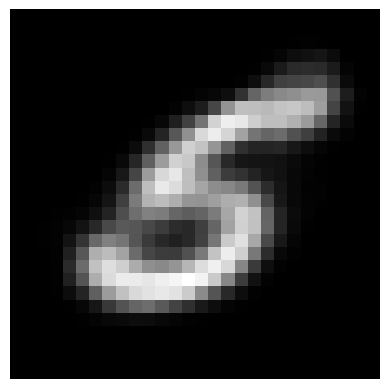

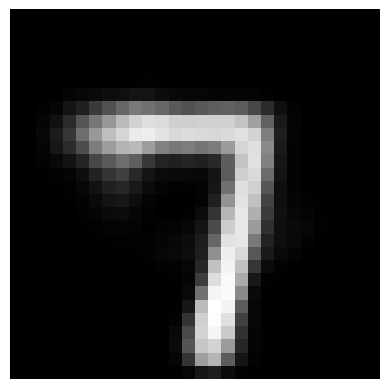

(None, None)

In [21]:
def generate_digit(z1, z2):
    z_sample = torch.tensor([[z1, z2]], dtype=torch.float).to(device)
    x_decoded = model.decode(z_sample)
    digit = x_decoded.detach().cpu().reshape(28, 28) # reshape vector to 2d array
    plt.imshow(digit, cmap='gray')
    plt.axis('off')
    plt.show()

generate_digit(0.0, 1.0), generate_digit(1.0, 0.0)

More impressive view of latent space

/tmp/ipython-input-1901758076.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit


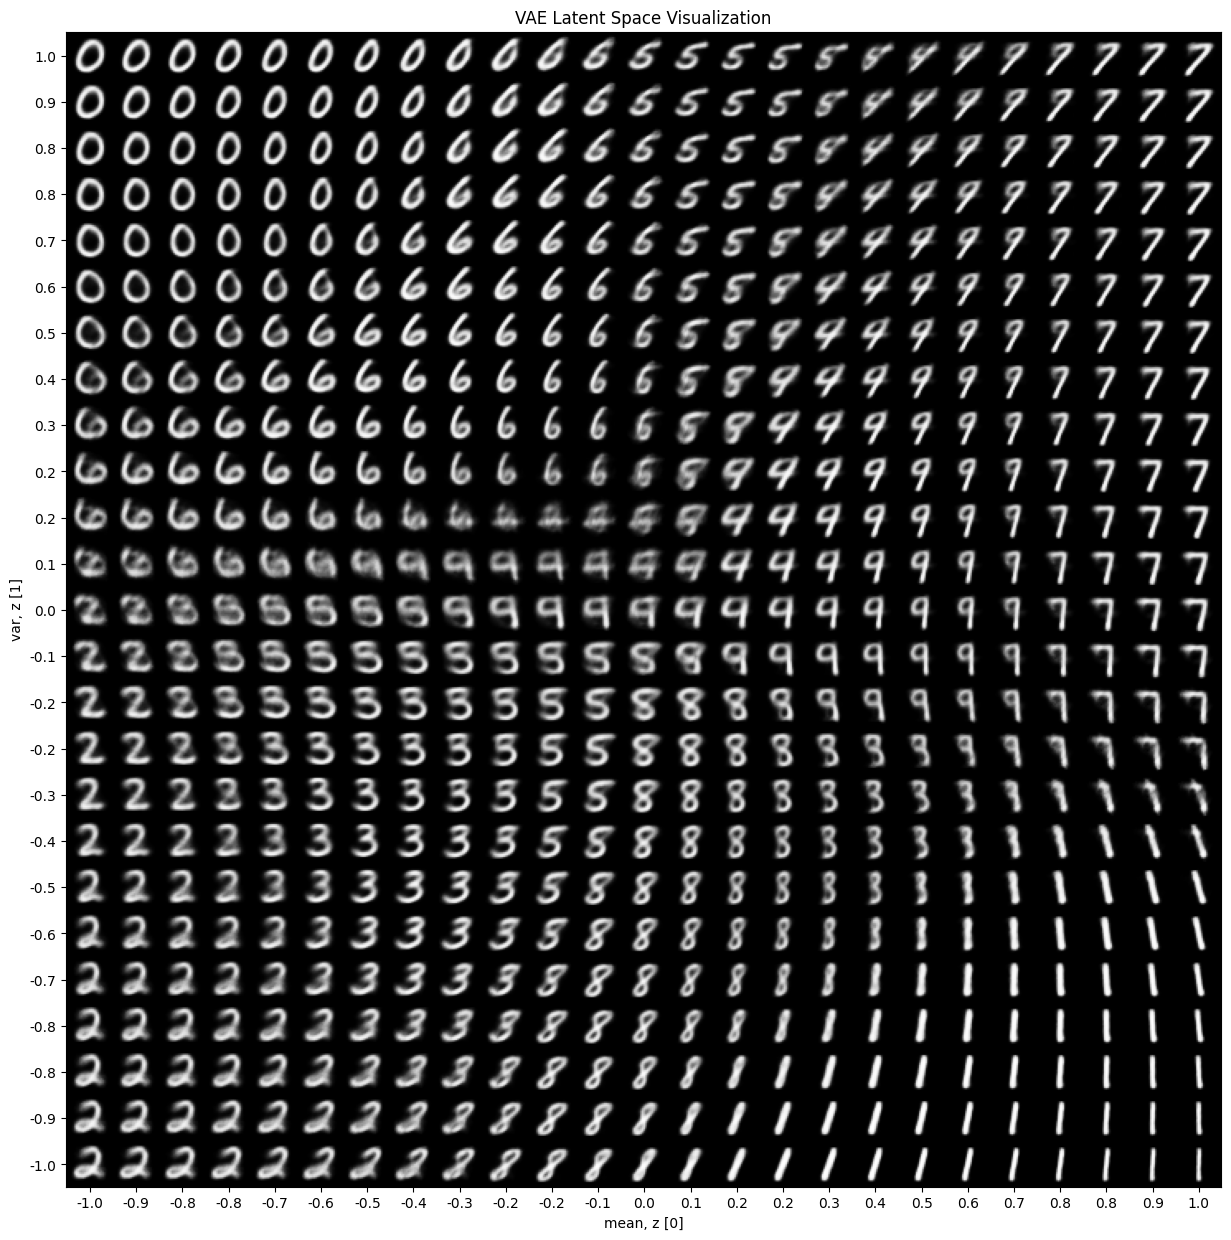

In [22]:
def plot_latent_space(model, scale=1.0, n=25, digit_size=28, figsize=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(device)
            x_decoded = model.decode(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("mean, z [0]")
    plt.ylabel("var, z [1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(model)